In [1]:
import tensorflow as tf
from ASR_Network import ASR_Network
from DataPipe import DataPipeFactory
from util_function import inform_pooling

/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/Users/jackwang/.local/share/virtualenvs/Code-_CZGGnvj/lib/python3.9/site-packages/tensorflow_io/p

In [2]:
# Disable all GPUS
tf.config.set_visible_devices([], 'GPU')
visible_devices = tf.config.get_visible_devices()
for device in visible_devices:
    assert device.device_type != 'GPU'

In [3]:
ds = DataPipeFactory('../DataFolder/Tensorflow_DataRecord/Student_Answer_Record.tfrecord',
                     '../DataFolder/Siri_Related/Siri_Reference_Sample',
                     '../DataFolder/Siri_Related/Siri_Dense_Index', cache='../DataFolder/cache/datapipe/cached')
# dsp = ds.get_batch_data(10)
# it = iter(dsp)
ds.get_raw_data()

Load cache from ../DataFolder/cache/datapipe/cached


<_LoadDataset element_spec={'ref_mfcc': TensorSpec(shape=(4, None, 80), dtype=tf.float32, name=None), 'MatchSegment': TensorSpec(shape=(4, None), dtype=tf.int64, name=None), 'valid_ref_word': TensorSpec(shape=(4, None), dtype=tf.int64, name=None), 'MatchReference': TensorSpec(shape=(4, None), dtype=tf.int64, name=None), 'valid_ref_start': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'RecordName': TensorSpec(shape=(), dtype=tf.string, name=None), 'passage_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'valid_ref_duration': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'valid_stu_duration': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'valid_stu_start': TensorSpec(shape=(4, None), dtype=tf.float32, name=None), 'stu_mfcc': TensorSpec(shape=(None, 80), dtype=tf.float32, name=None)}>

In [12]:
base_feature = ([None, 80], 512, [128, 256, 384, 512], 3, 2)
base_feature_name = ('input_shape', 'feature_depth', 'channels_list', 'filter_size', 'stack_size')
dense_feature = ([1280], 512, [512, 512], 2)
dense_feature_name = ('input_shape', 'output_shape', 'channels_list', 'stack_size')
word_prediction = ([512], 2500, [512, 1024], 2)
word_prediction_name = ('input_shape', 'output_shape', 'channels_list', 'stack_size')
# Generate dict using zip
# base_feature = dict(zip(base_feature_name, base_feature))
# dense_feature = dict(zip(dense_feature_name, dense_feature))
# word_prediction = dict(zip(word_prediction_name, word_prediction))
base_ratio = 125
hyper_para = {'base_feature': dict(zip(base_feature_name, base_feature)),
              'dense_feature': dict(zip(dense_feature_name, dense_feature)),
              'word_prediction': dict(zip(word_prediction_name, word_prediction)),
              'base_ratio': base_ratio}
C = ASR_Network(**hyper_para)

In [13]:
def unpack(d):
    value_s = d['stu_mfcc']
    start_s = tf.RaggedTensor.from_tensor(d['valid_stu_start'], padding=-1.)
    duration_s = tf.RaggedTensor.from_tensor(d['valid_stu_duration'], padding=-1.)

    #unpack with another key ref_mfcc, valid_ref_start, valid_ref_duration
    value_f = d['ref_mfcc']
    start_f = tf.RaggedTensor.from_tensor(d['valid_ref_start'], padding=-1.)
    duration_f = tf.RaggedTensor.from_tensor(d['valid_ref_duration'], padding=-1.)

    # unpack valid_ref_word

    words = tf.RaggedTensor.from_tensor(d['valid_ref_word'], padding=-1)
    return ((value_s, (start_s, duration_s)), (value_f, (start_f, duration_f))), words

In [14]:
dst = ds.get_batch_data(10, addition_map=unpack)

In [15]:
it = iter(dst)

In [16]:
data = next(it)

In [17]:
def call(self, inputs, training=False, mask=None):
    audio, (start, duration) = inputs
    # compute the base network
    base_output, maps = self.base_network(audio, training=training)
    # combine base output and maps
    total_maps = [base_output] + maps
    # pooling the total maps
    pooled_maps = self.pooling(total_maps, start, duration)
    # compute the deep feature
    deep_feature = self.deep_feature(pooled_maps, training=training)
    # compute the word prediction
    word_prediction = self.word_prediction(deep_feature, training=training)
    return word_prediction, deep_feature

In [18]:
C(data[0][0])

(<tf.RaggedTensor [[[-0.30528855, -0.10974575, 0.94357693, ..., -0.34247726, 0.6605787,
    -0.104454905],
   [-0.88235694, 1.1487213, 0.64867103, ..., -0.60031396, 0.6228409,
    0.3958601],
   [0.8050341, -0.046392336, 1.6691165, ..., -1.1224172, 1.3879687,
    1.5555485],
   ...,
   [0.984089, 0.60026586, -0.10742656, ..., 0.8306242, -0.42670918,
    2.1260626],
   [-1.5543141, -0.8812745, -0.35053217, ..., -0.8604648, -0.77518713,
    1.8575981],
   [-1.6935356, -1.0833278, -0.37722787, ..., -0.8160868, -0.09871314,
    1.7731862]]                                                       ,
  [[-0.37643448, 0.79967844, -0.7931688, ..., 0.008820668, 0.42610663,
    0.37854427],
   [-0.79892504, 0.34960783, 0.059774697, ..., -0.17863423, 0.07716012,
    1.4380043],
   [-0.31139013, 0.7818318, -1.6267308, ..., 2.2887437, 1.1106136, 3.071456],
   ...,
   [-0.81202865, -0.6251979, -0.5696568, ..., -0.44005, -0.80346066,
    1.3982747],
   [-1.0423056, -0.18461034, -2.1357932, ..., -1.056899

In [19]:
C.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

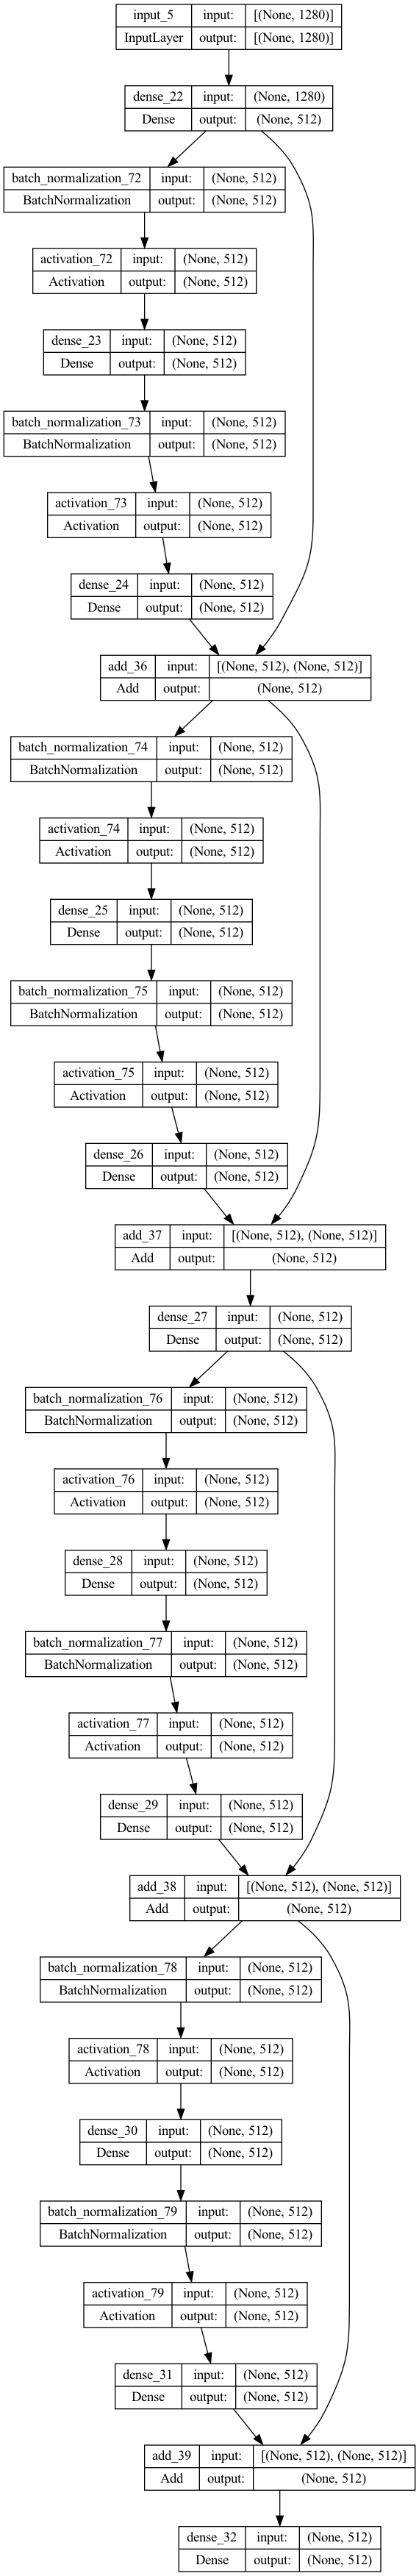

In [20]:
tf.keras.utils.plot_model(C.deep_feature,expand_nested=True, show_shapes=True, show_layer_names=True)

In [ ]:
C.fit(dst, epochs=1)

In [ ]:
nl = tf.keras.layers.BatchNormalization()

In [ ]:
Ragg1 = tf.RaggedTensor.from_row_splits(tf.random.normal([100,80]), row_splits=tf.range(0, 101, 5))
Ragg2 = tf.RaggedTensor.from_row_splits(tf.random.normal([100,80]), row_splits=tf.range(0, 101, 10))

In [ ]:
tf.ragged.map_flat_values(nl, Ragg2)

In [ ]:
class RaggedBatchNormalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization(**kwargs)

    def call(self, inputs, training=None, mask=None):
        # Pass `training` and `mask` arguments to the `call` method of the BatchNormalization layer
        return tf.ragged.map_flat_values(
            lambda x: self.batch_norm(x, training=training, mask=mask), inputs
        )

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return super().from_config(config)

In [ ]:
rnl = RaggedBatchNormalization()

In [ ]:
rnl(Ragg1)

In [ ]:
nl(tf.random.normal([100,80]))

In [ ]:
Ragg1.ragged_rank

In [ ]:
Ragg1.shape